In [1]:
!nvidia-smi

Fri Jun 10 20:35:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Kaggle/JPX

/content/drive/MyDrive/Kaggle/JPX


In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from time import time


##Data

In [5]:
TRAIN_DIR = "/content/drive/MyDrive/Kaggle/JPX/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv"
df_prices = pd.read_csv(TRAIN_DIR)

In [6]:
df_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [7]:
df_1301 = df_prices[df_prices['SecuritiesCode'] == 1301].reset_index(drop = True)

In [8]:
df_1301 = df_1301[['Date','Close']]
df_1301

,Date,Close
0,2017-01-04,2742.0
1,2017-01-05,2738.0
2,2017-01-06,2740.0
3,2017-01-10,2748.0
4,2017-01-11,2745.0
...,...,...
1197,2021-11-29,2951.0
1198,2021-11-30,2900.0
1199,2021-12-01,2911.0
1200,2021-12-02,2933.0


In [9]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
         pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

In [10]:
df_1301 = df_1301.sort_values(by = "Date").reset_index()

df_1301['RSI'] = RSI( df_1301['Close'], 14 )

In [11]:
df_1301

,index,Date,Close,RSI
0,0,2017-01-04,2742.0,NaN
1,1,2017-01-05,2738.0,NaN
2,2,2017-01-06,2740.0,NaN
3,3,2017-01-10,2748.0,NaN
4,4,2017-01-11,2745.0,NaN
...,...,...,...,...
1197,1197,2021-11-29,2951.0,38.548081
1198,1198,2021-11-30,2900.0,34.051847
1199,1199,2021-12-01,2911.0,35.791435
1200,1200,2021-12-02,2933.0,39.243290


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
df_1301['Close'] = scaler.fit_transform(df_1301['Close'].values.reshape(-1,1))
df_1301['RSI'] = scaler.fit_transform(df_1301['RSI'].values.reshape(-1,1))
df_1301

,index,Date,Close,RSI
0,0,2017-01-04,-0.576833,NaN
1,1,2017-01-05,-0.580570,NaN
2,2,2017-01-06,-0.578702,NaN
3,3,2017-01-10,-0.571228,NaN
4,4,2017-01-11,-0.574031,NaN
...,...,...,...,...
1197,1197,2021-11-29,-0.381597,-0.426345
1198,1198,2021-11-30,-0.429239,-0.539901
1199,1199,2021-12-01,-0.418963,-0.495966
1200,1200,2021-12-02,-0.398412,-0.408787


In [13]:
df_1301 = df_1301[['RSI','Close']].fillna(-1)
df_1301

,RSI,Close
0,-1.000000,-0.576833
1,-1.000000,-0.580570
2,-1.000000,-0.578702
3,-1.000000,-0.571228
4,-1.000000,-0.574031
...,...,...
1197,-0.426345,-0.381597
1198,-0.539901,-0.429239
1199,-0.495966,-0.418963
1200,-0.408787,-0.398412


In [14]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0:1]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,0:1]
    
    return [x_train, y_train, x_test, y_test]


In [15]:
lookback = 14
x_train, y_train, x_test, y_test = split_data(df_1301, lookback)

In [16]:
x_train.shape

(950, 13, 2)

In [17]:
y_train.shape

(950, 1)

## LSTM Model

In [18]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)


In [19]:
y_train_lstm.shape

torch.Size([950, 1])

In [20]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc =  nn.Linear(hidden_size, num_classes)
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #internal state
        # Propagate input through LSTM
        out, (hn, cn) = self.lstm(x, (h_0.detach(), c_0.detach())) #lstm with input, hidden, and internal state
        out = self.fc(out[:,-1,:]) #Final Output
        return out

### Train

In [21]:
num_epochs = 100 #1000 epochs
learning_rate = 0.01 #0.001 lr

input_size = 2 #number of features
hidden_size = 32 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [22]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [23]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [24]:
for epoch in range(num_epochs):
  outputs = lstm.forward(x_train) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_lstm)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  print("Epoch: %d, loss: %f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.098729
Epoch: 1, loss: 0.096881
Epoch: 2, loss: 0.088831
Epoch: 3, loss: 0.084109
Epoch: 4, loss: 0.072612
Epoch: 5, loss: 0.064907
Epoch: 6, loss: 0.047752
Epoch: 7, loss: 0.055736
Epoch: 8, loss: 0.071113
Epoch: 9, loss: 0.039262
Epoch: 10, loss: 0.040458
Epoch: 11, loss: 0.045979
Epoch: 12, loss: 0.044844
Epoch: 13, loss: 0.042458
Epoch: 14, loss: 0.040706
Epoch: 15, loss: 0.038678
Epoch: 16, loss: 0.035378
Epoch: 17, loss: 0.031034
Epoch: 18, loss: 0.027820
Epoch: 19, loss: 0.028753
Epoch: 20, loss: 0.031688
Epoch: 21, loss: 0.030589
Epoch: 22, loss: 0.027403
Epoch: 23, loss: 0.025609
Epoch: 24, loss: 0.025083
Epoch: 25, loss: 0.024874
Epoch: 26, loss: 0.024739
Epoch: 27, loss: 0.024739
Epoch: 28, loss: 0.024737
Epoch: 29, loss: 0.024367
Epoch: 30, loss: 0.023416
Epoch: 31, loss: 0.022201
Epoch: 32, loss: 0.021418
Epoch: 33, loss: 0.021442
Epoch: 34, loss: 0.021817
Epoch: 35, loss: 0.021774
Epoch: 36, loss: 0.021207
Epoch: 37, loss: 0.020612
Epoch: 38, loss: 0.020

In [25]:
y_train_lstm.shape

torch.Size([950, 1])

In [26]:
outputs.shape

torch.Size([950, 1])

In [27]:
predict = pd.DataFrame(scaler.inverse_transform(outputs.detach().numpy()))


In [28]:
origin = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

Text(0.5, 1.0, 'price')

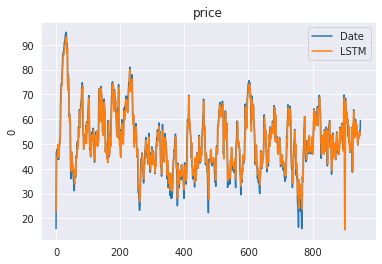

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

fig = plt.figure()


ax = sns.lineplot(x=origin.index,y=origin[0],label='Date')
ax = sns.lineplot(x=predict.index,y=predict[0],label='LSTM')
ax.set_title('price')


In [30]:
from sklearn.metrics import mean_squared_error
import math
y_test_pred = lstm(x_test)

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())
test = mean_squared_error(y_test[:,0],y_test_pred[:,0])

In [31]:
test

23.246006